In [2]:
#IPython notebook plot formatting
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

import matplotlib.pyplot as plt

#Load the modules
import Extractors as e
import Classifiers as c
import DoyleMLToolkit as dmlt

#Make sure they get reloaded after changes
e = reload(e)
c = reload(c)
dmlt = reload(dmlt)

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Define high order models to generate accurate variances

order = 12
zeroth = 0
positive = "Normal"
data = ["17NovemberSim/simClasses.csv"]+["17NovemberSim/sim4_%d.csv"%i for i in range(1,8)]
#data = ["17NovemberSim/simClasses.csv"]+["1DecemberSim/simK_%d.csv"%i for i in range(1,8)]
#data = ["17NovemberSim/simClasses.csv"]+["1DecemberSim/simTau_%d.csv"%i for i in range(1,8)]
CancerModels = [
    dmlt.Model(e.ComplexFourier,c.NaiveBayesReal,order,0),
    #dmlt.Model(e.Chebyshev,c.NaiveBayesReal,order,0),
    dmlt.Model(e.Bernstein,c.NaiveBayesReal,order,0)
]


#Load relevant data

#KidneyData = [model.load(data[0],data[1])+model.load(data[0],data[2])+model.load(data[0],data[3]) for model in CancerModels]
KidneyData = []
for model in CancerModels:
    newModel = model.load(data[0],data[1])
    for i in data[2:]:
        newModel += model.load(data[0],i)
    KidneyData.append(newModel)
print list(set(KidneyData[0].getAllY()))

#Generate variances for ALL data
# varReal = []
# varImag = []
# for model in KidneyData:
#     varReal.append(model.getVariances(0,0,zeroth))
#     varImag.append(model.getVariances(1,0,zeroth))

#Calculate variances among classifications of data
varReal = []
varImag = []
for model in KidneyData:
    #print CancerModels[KidneyData.index(model)].C.name
    benign = []
    malignant = []
    normal = []
    for sweep in range(model.size):
        if model.getAllY()[sweep] == "Benign":
            benign.append(sweep)
        if model.getAllY()[sweep] == "Malignant":
            malignant.append(sweep)
        if model.getAllY()[sweep] == "Normal":
            normal.append(sweep)

    bToken = model.genSubtoken(benign)
    mToken = model.genSubtoken(malignant)
    nToken = model.genSubtoken(normal)

    #Use variances for ONE of the classifications
    varReal.append(nToken.getVariances(0,0,zeroth))
    varImag.append(nToken.getVariances(1,0,zeroth))

#Replace each array with a set of tuples (index,value) of the n highest variances
n = 3
for model in range(len(varReal)):
    tmp1 = []
    tmp2 = []
    for i in range(n):
        tmp1.append((varReal[model].index(max(varReal[model])),max(varReal[model])))
        varReal[model][tmp1[-1][0]] = -1
        
        tmp2.append((varImag[model].index(max(varImag[model])),max(varImag[model])))
        varImag[model][tmp2[-1][0]] = -1
    varReal[model] = tmp1
    varImag[model] = tmp2

for i in range(len(varReal)):
    print varReal[i]
    print varImag[i]
    print ''

#Order things nicely
var = []
nn = 2
for j in range(2):
    for i in range(nn):
        var.append(varReal[i])
    for i in range(nn):
        var.append(varImag[i])

['Benign', 'Malignant', 'Normal']
[(0, 0.73429264102663672), (1, 0.05289566249431716), (5, 0.025140870462267099)]
[(0, 0.73497951465563194), (1, 0.12292075635067283), (2, 0.04370383365105264)]

[(0, 0.17467767692616334), (1, 0.16202795513182203), (2, 0.14234769396107957)]
[(10, 0.29371357326071157), (9, 0.2180540323310772), (8, 0.13685552961845654)]



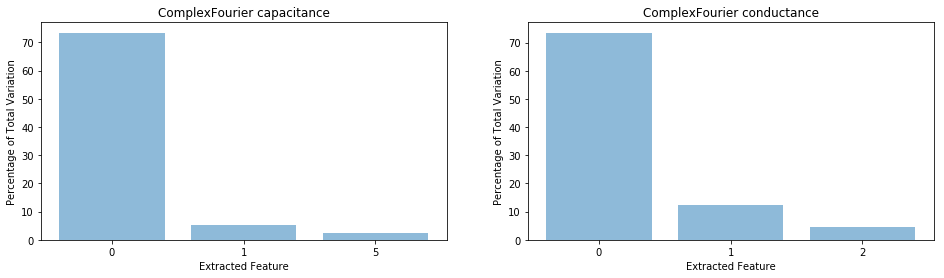

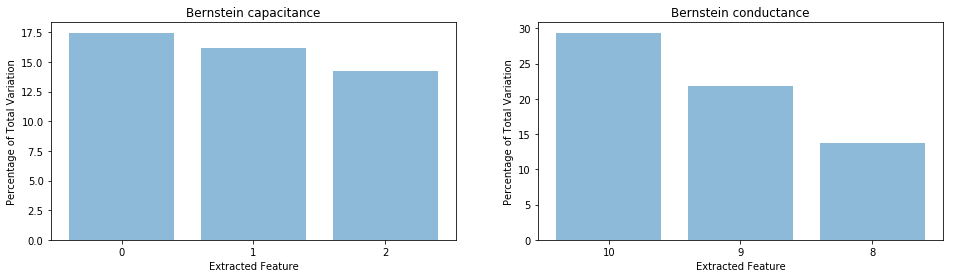

In [12]:
#Plot variances
pylab.rcParams['figure.figsize'] = (16, 4)


for model in range(len(KidneyData)):
    #Real
    objects = [str(i[0]) for i in varReal[model]]
    y_pos = np.arange(len(objects))
    performance = [100*i[1] for i in varReal[model]]

    plt.subplot(121)
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Percentage of Total Variation')
    plt.xlabel('Extracted Feature')
    plt.title(CancerModels[model].C.name+' capacitance')

    #Imaginary
    objects = [str(i[0]) for i in varImag[model]]
    y_pos = np.arange(len(objects))
    performance = [100*i[1] for i in varImag[model]]

    plt.subplot(122)
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Percentage of Total Variation')
    plt.xlabel('Extracted Feature')
    plt.title(CancerModels[model].C.name+' conductance')

    plt.show()

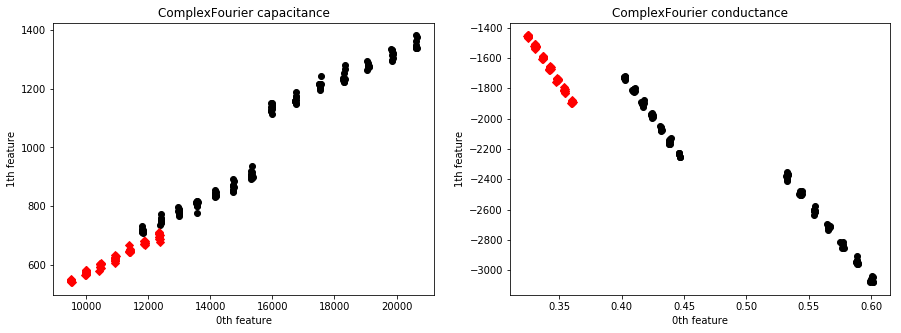

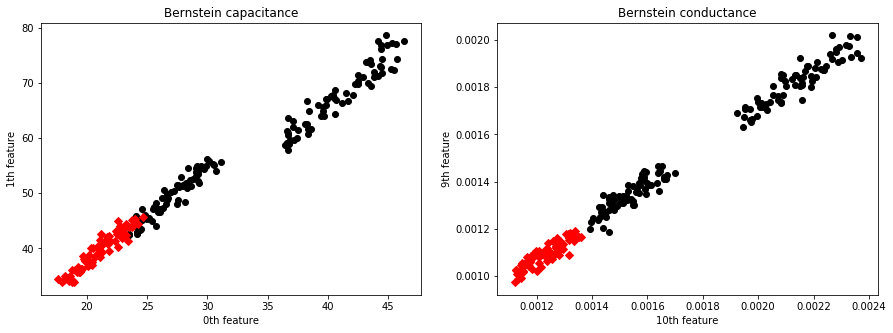

In [13]:
#Component plots
pylab.rcParams['figure.figsize'] = (15, 5)


for model in range(len(KidneyData)):
    #Real
    imaginary = 0
    classes = sorted(list(set(KidneyData[model].getAllY())))
    colors = ['red','orange','yellow','green','blue']

    x = 0
    y = 0
    plt.subplot(121)
    for row in range(len(KidneyData[model].getAllFeatures()[0])):
        x = KidneyData[model].getFeaturesBySweep(row,0,imaginary)[varReal[model][0][0]]
        y = KidneyData[model].getFeaturesBySweep(row,0,imaginary)[varReal[model][1][0]]
        if KidneyData[model].getAllY()[row] == positive:
            plt.plot([x],[y],color='#ff0000',marker='D',linewidth=0)
        else:
            plt.plot([x],[y],color='#000000',marker='o',linewidth=0)
        #plt.annotate(str(row),(x+(1e-12),y+(3e-6)))

    plt.title(CancerModels[model].C.name+" capacitance")
    plt.xlabel("%dth feature"%varReal[model][0][0])
    plt.ylabel("%dth feature"%varReal[model][1][0])

    #Imaginary
    imaginary = 1
    classes = sorted(list(set(KidneyData[model].getAllY())))
    colors = ['red','orange','yellow','green','blue']

    x = 0
    y = 0
    plt.subplot(122)
    for row in range(len(KidneyData[model].getAllFeatures()[0])):
        x = KidneyData[model].getFeaturesBySweep(row,0,imaginary)[varImag[model][0][0]]
        y = KidneyData[model].getFeaturesBySweep(row,0,imaginary)[varImag[model][1][0]]
        if KidneyData[model].getAllY()[row] == positive:
            plt.plot([x],[y],color='#ff0000',marker='D',linewidth=0)
        else:
            plt.plot([x],[y],color='#000000',marker='o',linewidth=0)
        #plt.annotate(str(row),(x-(1e-5),y+(0.9e-6)))

    plt.title(CancerModels[model].C.name+" conductance")
    plt.xlabel("%dth feature"%varImag[model][0][0])
    plt.ylabel("%dth feature"%varImag[model][1][0])
    plt.show()

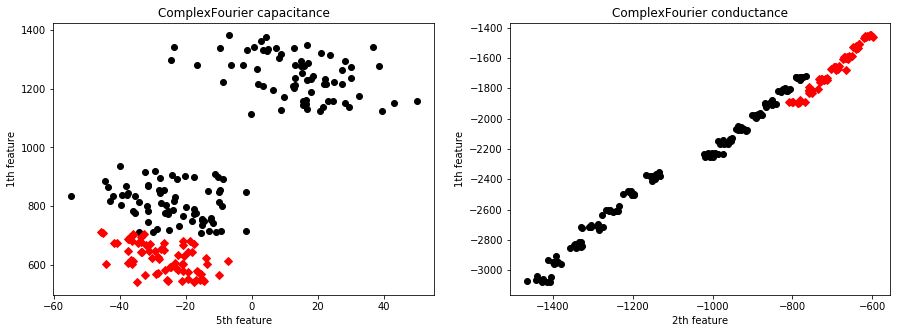

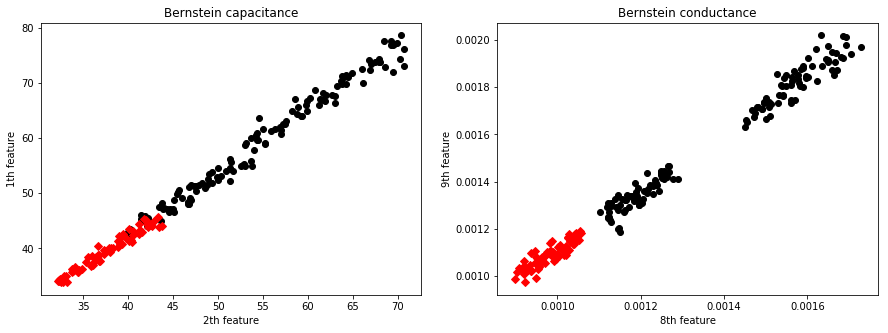

In [14]:
#Component plots
pylab.rcParams['figure.figsize'] = (15, 5)


for model in range(len(KidneyData)):
    #Real
    imaginary = 0
    classes = sorted(list(set(KidneyData[model].getAllY())))
    colors = ['red','orange','yellow','green','blue']

    x = 0
    y = 0
    plt.subplot(121)
    for row in range(len(KidneyData[model].getAllFeatures()[0])):
        x = KidneyData[model].getFeaturesBySweep(row,0,imaginary)[varReal[model][-1][0]]
        y = KidneyData[model].getFeaturesBySweep(row,0,imaginary)[varReal[model][-2][0]]
        if KidneyData[model].getAllY()[row] == positive:
            plt.plot([x],[y],color='#ff0000',marker='D',linewidth=0)
        else:
            plt.plot([x],[y],color='#000000',marker='o',linewidth=0)
        #plt.annotate(str(row),(x+(1e-12),y+(3e-6)))

    plt.title(CancerModels[model].C.name+" capacitance")
    plt.xlabel("%dth feature"%varReal[model][-1][0])
    plt.ylabel("%dth feature"%varReal[model][-2][0])

    #Imaginary
    imaginary = 1
    classes = sorted(list(set(KidneyData[model].getAllY())))
    colors = ['red','orange','yellow','green','blue']

    x = 0
    y = 0
    plt.subplot(122)
    for row in range(len(KidneyData[model].getAllFeatures()[0])):
        x = KidneyData[model].getFeaturesBySweep(row,0,imaginary)[varImag[model][-1][0]]
        y = KidneyData[model].getFeaturesBySweep(row,0,imaginary)[varImag[model][-2][0]]
        if KidneyData[model].getAllY()[row] == positive:
            plt.plot([x],[y],color='#ff0000',marker='D',linewidth=0)
        else:
            plt.plot([x],[y],color='#000000',marker='o',linewidth=0)
        #plt.annotate(str(row),(x-(1e-5),y+(0.9e-6)))

    plt.title(CancerModels[model].C.name+" conductance")
    plt.xlabel("%dth feature"%varImag[model][-1][0])
    plt.ylabel("%dth feature"%varImag[model][-2][0])
    plt.show()

In [5]:
e_l = ([7056.4]*10 + [8837.7]*10 + [11702.3]*10)*7

for model in range(len(KidneyData)):
    A = np.matrix([[KidneyData[model].getFeaturesBySweep(i,0,0)[varReal[model][j][0]] for j in range(len(varReal))] for i in range(KidneyData[model].size)])
    y = np.array(e_l)
    print A.shape,y.shape
    
    solution = np.linalg.lstsq(A,y)[0]
    
    error = []
    for i in range(KidneyData[model].size):
        estimate = np.array([KidneyData[model].getFeaturesBySweep(i,0,0)[varReal[model][j][0]] for j in range(len(varReal))]).dot(solution)
        error.append(np.abs(e_l[i]-estimate)/e_l[i])
        #print error[-1]
    print min(error),sum(error)/len(error),max(error)
    print ''

(210, 2) (210,)
0.00883939588082 0.0737334037189 0.153862320953

(210, 2) (210,)
7.47359034889e-07 0.0745216766725 0.172189397343



In [16]:
CancerModels = [
    dmlt.Model(e.ComplexFourier,c.NaiveBayesReal,order,1),
    #dmlt.Model(e.Chebyshev,c.NaiveBayesReal,order,1),
    dmlt.Model(e.Bernstein,c.NaiveBayesReal,order,1)
]


#Load relevant data

KidneyData = []
for model in CancerModels:
    newModel = model.load(data[0],data[1])
    for i in data[2:]:
        newModel += model.load(data[0],i)
    KidneyData.append(newModel)

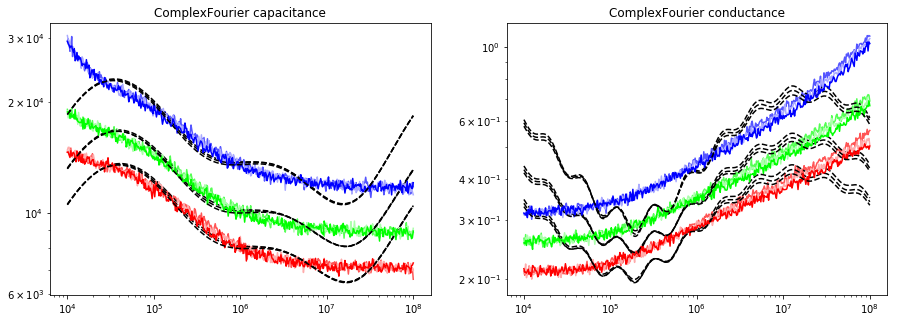

In [8]:
#Reconstructed plots

rows = [10*i for i in range(9)]
colors = ['#ff5555','#55ff55','#5555ff','#ffABAB','#ABffAB','#ABABff','#ff0000','#00ff00','#0000ff']
for model in range(len(KidneyData))[:1]:
        #Real
        feats = [var[model][0][0],var[model][1][0],var[model][2][0]]
        imaginary = 0
        plt.subplot(121)
        plt.xscale('log')
        plt.yscale('log')
        plt.title(CancerModels[model].C.name+" capacitance")
        for row in range(len(rows)):
            CancerModels[model].plotSample(KidneyData[model],rows[row],colors[row],imaginary)
            CancerModels[model].plotApproximation(KidneyData[model],rows[row],'k--',imaginary,0,feats)

        #Imaginary
        feats = [var[model+2][0][0],var[model+2][1][0],var[model+2][2][0]]
        imaginary = 1
        plt.subplot(122)
        plt.xscale('log')
        plt.yscale('log')
        plt.title(CancerModels[model].C.name+" conductance")
        for row in range(len(rows)):
            CancerModels[model].plotSample(KidneyData[model],rows[row],colors[row],imaginary)
            CancerModels[model].plotApproximation(KidneyData[model],rows[row],'k--',imaginary,0,feats)

        plt.show()

In [9]:
#Redefine models at without zeroth to make actual classifications

CancerModels = [
    dmlt.Model(e.ComplexFourier,c.NaiveBayesReal,order,zeroth),
    #dmlt.Model(e.Chebyshev,c.NaiveBayesReal,order,zeroth),
    dmlt.Model(e.Bernstein,c.NaiveBayesReal,order,zeroth),
    
    dmlt.Model(e.ComplexFourier,c.NaiveBayesImag,order,zeroth),
    #dmlt.Model(e.Chebyshev,c.NaiveBayesImag,order,zeroth),
    dmlt.Model(e.Bernstein,c.NaiveBayesImag,order,zeroth),


    dmlt.Model(e.ComplexFourier,c.NBKernelReal,order,zeroth),
    #dmlt.Model(e.Chebyshev,c.NBKernelReal,order,zeroth),
    dmlt.Model(e.Bernstein,c.NBKernelReal,order,zeroth),

    dmlt.Model(e.ComplexFourier,c.NBKernelImag,order,zeroth),
    #dmlt.Model(e.Chebyshev,c.NBKernelImag,order,zeroth),
    dmlt.Model(e.Bernstein,c.NBKernelImag,order,zeroth)
]


#Load relevant data

KidneyData = []
for model in CancerModels:
    newModel = model.load(data[0],data[1])
    for i in data[2:]:
        newModel += model.load(data[0],i)
    KidneyData.append(newModel)

ComplexFourier
Naive Bayes Real
140.0 0.0
0.0 70.0
[1.0, 1.0, 1.0, 1.0]

Bernstein
Naive Bayes Real
140.0 0.0
0.0 70.0
[1.0, 1.0, 1.0, 1.0]

ComplexFourier
Naive Bayes Imaginary
140.0 0.0
0.0 70.0
[1.0, 1.0, 1.0, 1.0]

Bernstein
Naive Bayes Imaginary
140.0 0.0
0.0 70.0
[1.0, 1.0, 1.0, 1.0]

ComplexFourier
Kernel Density Estimation Real


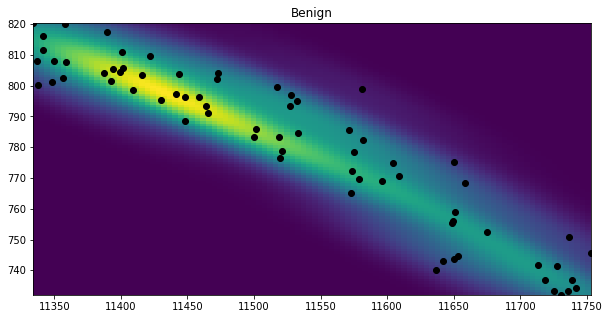

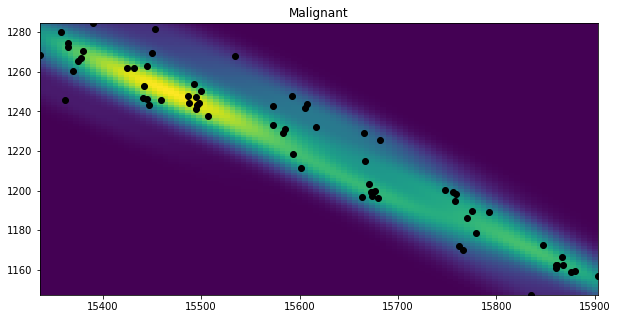

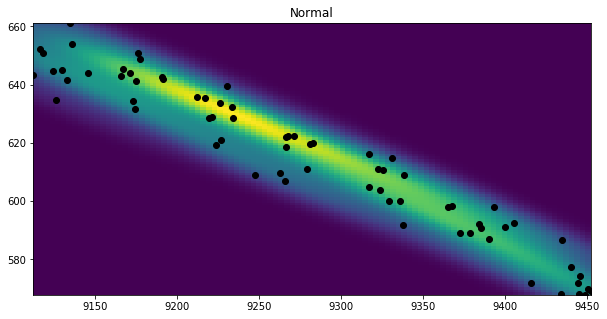

140.0 0.0
0.0 70.0
[1.0, 1.0, 1.0, 1.0]

Bernstein
Kernel Density Estimation Real


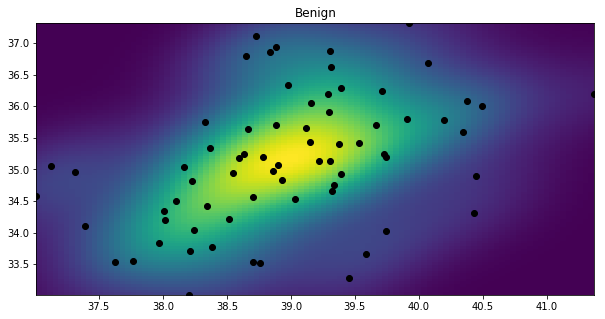

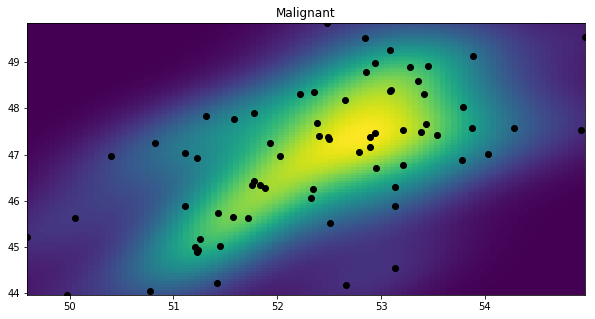

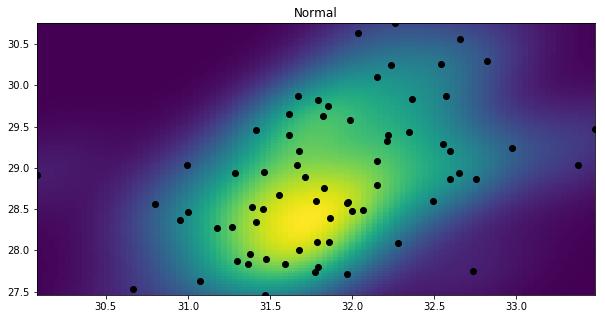

140.0 0.0
0.0 70.0
[1.0, 1.0, 1.0, 1.0]

ComplexFourier
Kernel Density Estimation Imaginary


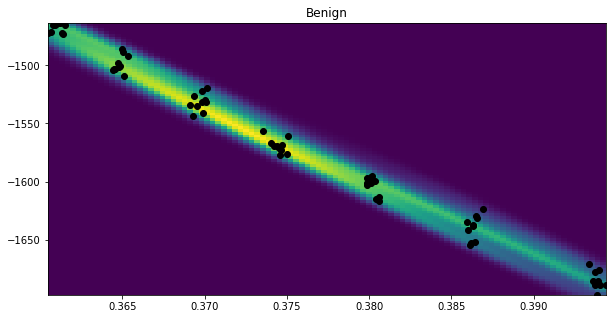

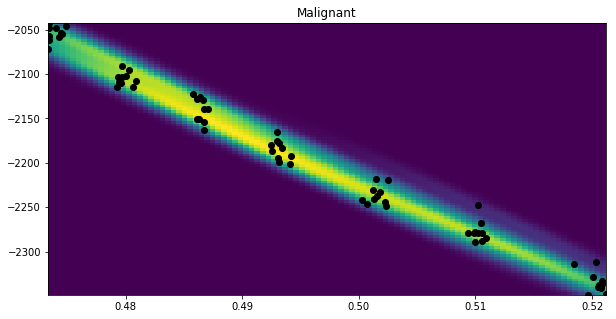

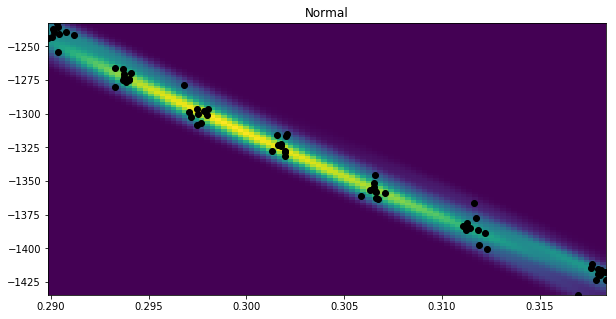

140.0 0.0
0.0 70.0
[1.0, 1.0, 1.0, 1.0]

Bernstein
Kernel Density Estimation Imaginary


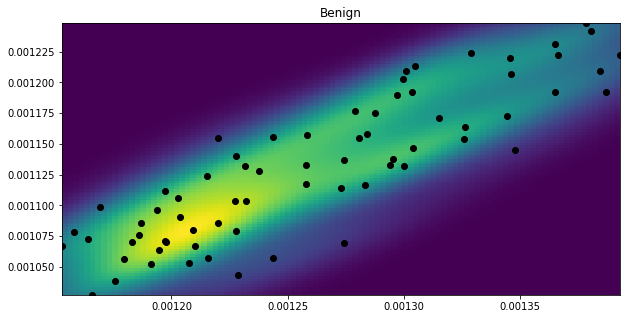

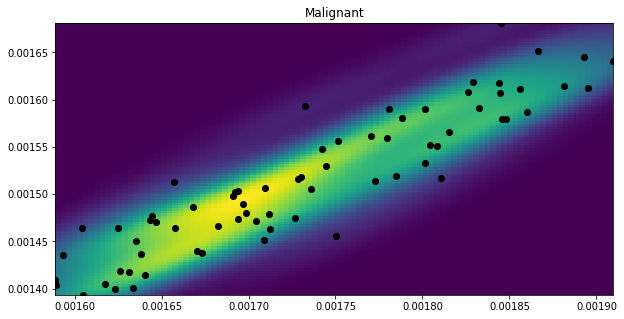

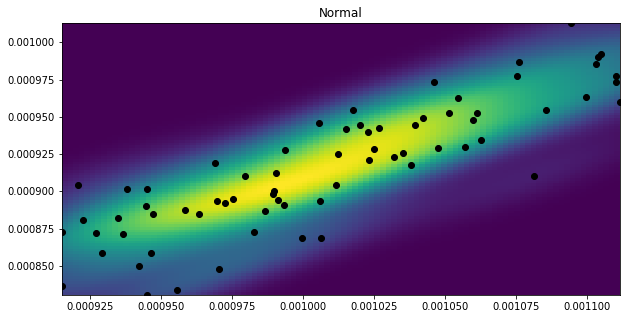

140.0 0.0
0.0 70.0
[1.0, 1.0, 1.0, 1.0]



In [10]:
pylab.rcParams['figure.figsize'] = (10, 5)

#Test model

for model in range(len(CancerModels)):
    CancerModels[model].train(KidneyData[model],[])
    print CancerModels[model].C.name
    print CancerModels[model].L.name
    feats = [var[model][0][0],var[model][1][0]]
    #print feats
    CancerModels[model].train(KidneyData[model],[],feats,1)
    #CancerModels[model].predict(KidneyData[model],KidneyData[model].getAllY())
    print CancerModels[model].test(KidneyData[model],positive,feats)
    print ''